## Predictining Boston house prices

### Ingest

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

from joblib import dump,load

In [65]:
# load dataset
df = pd.read_csv("../datasets/housing.xls", sep="\s+", 
                   names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])


df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### EDA

In [66]:
# data shape 
df.shape

(506, 14)

In [67]:
# information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [68]:
# retrieve the columns of the dataframe into a list 
features = df.columns.to_list()


In [69]:
# data statistics 
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [70]:
# Check for null data 
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [71]:
# check for duplicates 
df.duplicated().sum()

np.int64(0)

#### Correlation matrix

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'LSTAT'),
  Text(1, 0, 'PTRATIO'),
  Text(2, 0, 'INDUS'),
  Text(3, 0, 'TAX'),
  Text(4, 0, 'NOX'),
  Text(5, 0, 'CRIM'),
  Text(6, 0, 'RAD'),
  Text(7, 0, 'AGE'),
  Text(8, 0, 'CHAS'),
  Text(9, 0, 'DIS'),
  Text(10, 0, 'B'),
  Text(11, 0, 'ZN'),
  Text(12, 0, 'RM')])

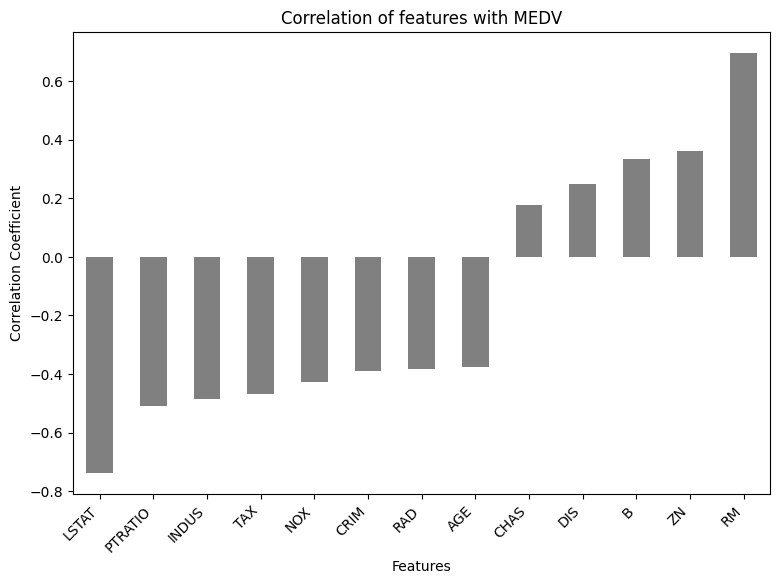

In [72]:
# correlation matrix with the target matrix 
# `MEDV`: Median value of owner-occupied homes in $1000s

medv_corr = df.corr()['MEDV']

# Plot the correlation matrix 
plt.figure(figsize=(9,6))
medv_corr.drop('MEDV').sort_values().plot(kind='bar',color='grey')
plt.title("Correlation of features with MEDV")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45,ha='right')

#### Detect outliers using boxplots


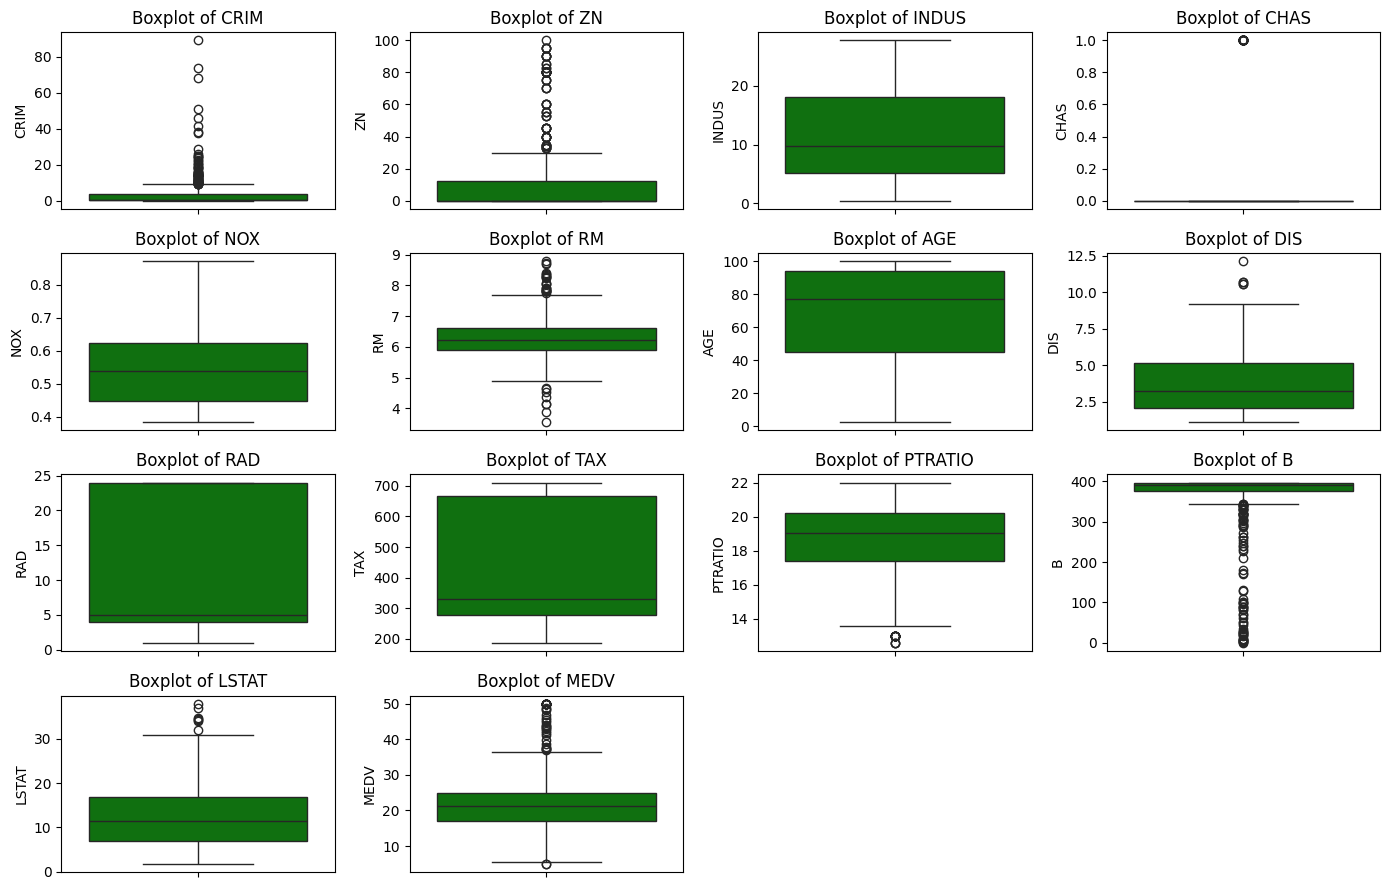

In [73]:
plt.figure(figsize=(14,9))
for i,feature in enumerate(features):
    plt.subplot(4,4,i+1)
    sns.boxplot(y=df[feature],color='green')
    plt.title(f"Boxplot of {feature}")
    plt.tight_layout()

Explanation of the boxplots (chose afew unique ones )
- `CRM` - The box plot shows a right-skewed distribution, with many outliers. Most values are concentrated near the lower end, indicating that most towns have a low crime rate, but a few towns have much higher crime rates.
- `ZN - The distribution has several outliers on the higher end, but most values are at or near zero. This indicates that most areas have little to no residential zoning for large lots, but a few towns have higher proportions of land zoned for large lots.
- `NOX` - The distribution is centered, with no extreme outliers. The concentration of NOX does not vary significantly between towns.
- `TAX` - The tax rate is fairly uniform, with no significant outliers. Most towns have a tax rate concentrated at a higher range.

#### Distribution 

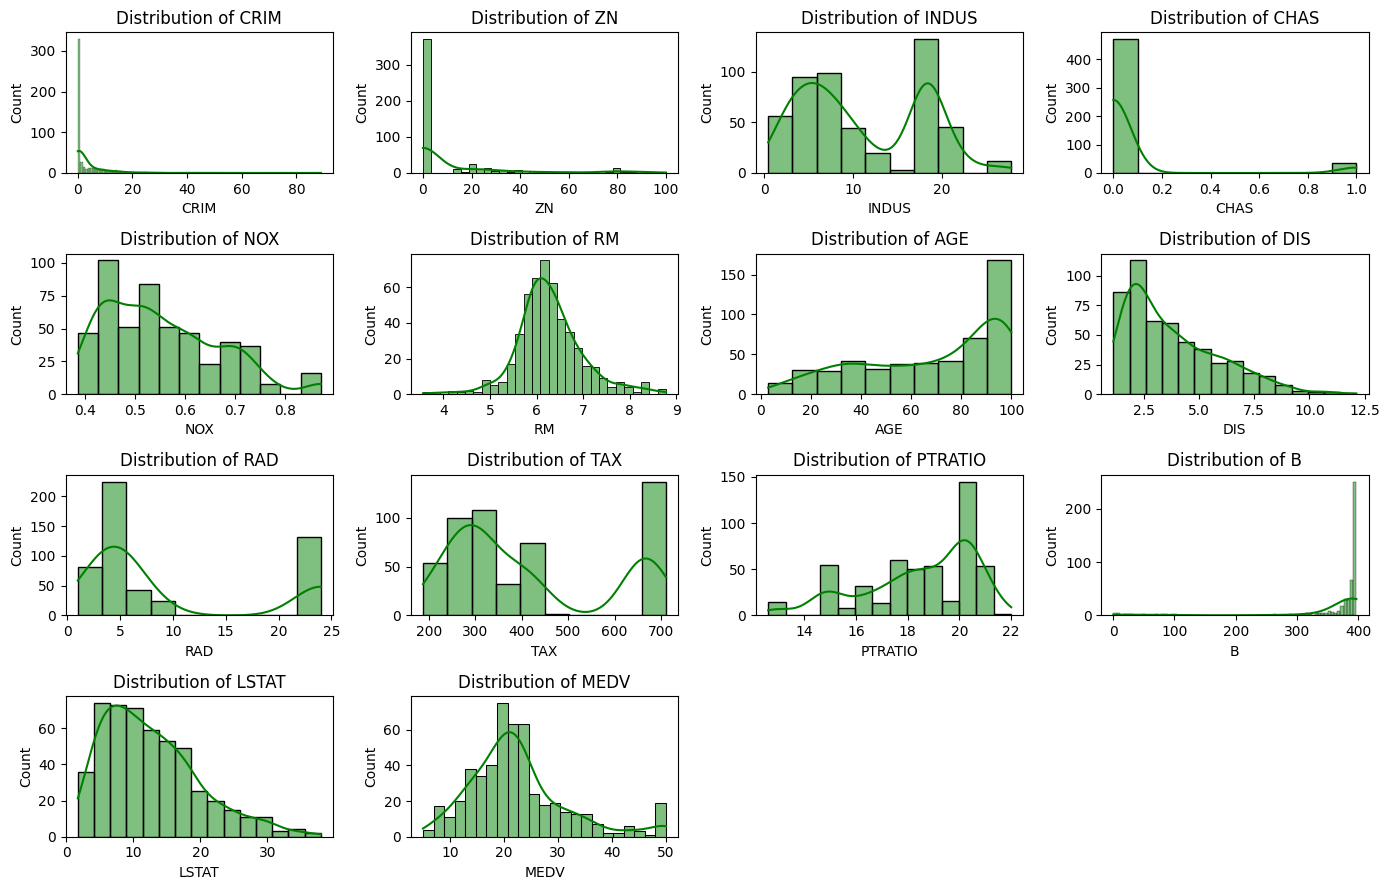

In [74]:
plt.figure(figsize=(14,9))
for i,feature in enumerate(features):
    plt.subplot(4,4,i+1)
    sns.histplot(df[feature],kde=True,color='green')
    plt.title(f"Distribution of {feature}")
    plt.tight_layout()

- some of the features are skewed. 
- This means we got to scale the full dataset.

### Modelling

In [75]:
# have the target variable separated from the rest of the features

X = df.drop("MEDV",axis=1)
y= df['MEDV']

# split thee data 
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

# Check the shapes of the resulting datasets
print(f"Training set features shape: {x_train.shape}")
print(f"Testing set features shape: {x_test.shape}")
print(f"Training set target shape: {y_train.shape}")
print(f"Testing set target shape: {y_test.shape}")



Training set features shape: (404, 13)
Testing set features shape: (102, 13)
Training set target shape: (404,)
Testing set target shape: (102,)


#### Feature engineering

In [76]:
# scaling 

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [77]:
# xgboost regressor 
model = XGBRegressor(object='reg:squarederror',random_state = 3)


# K-Fold cross validation
kfold = KFold(n_splits = 10,shuffle=True,random_state=3)

# hyperparameter grid 
param_grid ={
        'n_estimators': [100,200],
        'max_depth': [3,4,5],
        'learning_rate': [0.01,0.1],
        'subsample': [0.8,1.0],
        'colsample_bytree': [0.8,1.0]

}

# gridsearch cv with  kfold
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=kfold,
    verbose=1,
    n_jobs=-1

)

# fit the model using grid search on scaled training data 
grid_results = grid_search.fit(x_train_scaled,y_train)

# evaluate the best model on test data
best_model = grid_results.best_estimator_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/media/danlof/dan_files4/data_science_codes/MLOPS/flask-ml-azure-serverless/azure/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:30:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "object" } are not used.

  warnings.warn(smsg, UserWarning)
/media/danlof/dan_files4/data_science_codes/MLOPS/flask-ml-azure-serverless/azure/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:30:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "object" } are not used.

  warnings.warn(smsg, UserWarning)
/media/danlof/dan_files4/data_science_codes/MLOPS/flask-ml-azure-serverless/azure/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:30:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "object" } are not used.

  warnings.warn(smsg, UserWarning)
/media/danlof/dan_files4/data_science_codes/MLOPS/flask-ml-azure-serverless/azure/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:30:49] WARNING: /workspace/src/lear

#### Testing

In [78]:
# make predictions 
predictions = best_model.predict(x_test_scaled)

#### Evaluation

##### Feature importance 

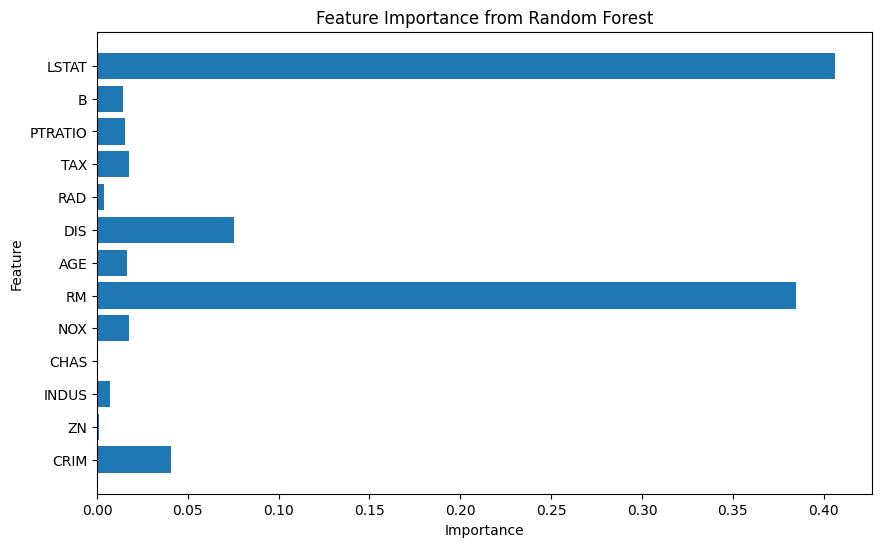

In [79]:

from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)

importances = rf_model.feature_importances_
# Plot the feature importance from Random Forest
plt.figure(figsize=(10, 6))
plt.barh(x_train.columns, importances)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [80]:
mse = mean_squared_error(y_test,predictions)
r2 = r2_score(y_test,predictions)

In [81]:
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)
print("Best Parameters:", grid_results.best_params_)

Mean Squared Error: 6.230644418621349
R-squared Score: 0.9255239288435331
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


#### Saving model

In [82]:
import os
# print(os.getcwd())

model_path = '../models/xgb_housing_model.joblib'

In [83]:
# save best model
dump(best_model,model_path)

['../models/xgb_housing_model.joblib']

In [84]:
# Use it when unloading the model
#  loaded_housing_model = load('xgb_housing_model.joblib')

### Conclusion

- In this analysis the Ml engineer has implemented a XGBoost regressor to predict housing prices based on the features from the data.
1.`Model performance`: The XGBoost regressor achieved a Mean Squared Error (MSE) of 6.23 and an R-squared score of 0.925, indicating that the model is highly effective at capturing the relationship between features and house prices. The low MSE reflects minimal prediction errors, while the R-squared score suggests that the model explains 92.5% of the variance in house prices, demonstrating strong predictive power compared to baseline models.
    
2. `Feature importance`: The most influential features—LSTAT (0.4), RM (0.38), DIS (.1), and CRIM (0.8)—account for much of the model's ability to predict housing prices. These features reflect key socio-economic factors (e.g., the percentage of lower-status residents, number of rooms, proximity to employment centers, and crime rates), all of which strongly affect real estate values in Boston.

3. `Actionable Insights` : Based on the model’s predictions, stakeholders can identify potentially undervalued or overvalued properties by comparing the predicted prices with actual market listings. Such insights can inform investment decisions, optimize pricing strategies, and guide resource allocation to maximize returns in the housing market. For instance, investors could target undervalued properties in high-demand areas for potential profits.

3. `Next Steps`:Moving forward, continuous monitoring of model performance is essential, especially as new data becomes available. The model should be retrained periodically (e.g., quarterly or semi-annually) to ensure it remains aligned with current market conditions. Additionally, incorporating new features (such as interest rates or zoning laws) could further improve prediction accuracy over time.
